In [2]:
# Part 1:
# This notebook generates some of the first figures, on coverage / length / pVOGs etc. 
# Part 2:
# calculates and rewraps some statistics used for host calling (crispr hits, tRNA's) later on.
# Part 3:
# PHATE dim reduction.

### Input files needed:
# - alltRNA_BACJGI_genomeacc.bln: BlastN output (tabular) of the predicted tRNA sequences against the bacteria db.
# - bacteria_names.txt: names of the bacteria included in the analysis
# - contignames.txt: names of the bacterial contigs included in the analysis
# - coverage_tpmean.tsv: coverages for the bacteriophages for all the samples analysed.
# - Crisprhits_red.bln: blastN output (tabular) of the bacterial crispr spacers against the bacteriophage sequences.
# - Link_GA_bacterium.txt: information between bacterial name and the bacterial contig ID
# - Putativephage_DNARNA.faa: raw fasta file containing the proteins as predicted by prodigal from Putativephage_DNARNA.faa
# - Putativephage_DNARNA.fna: raw fasta file clustered on 95% nt ID, over 80% length.
# - speccaccummat.csv: species accumulation curve generated by the speccacum.R script.
# - TotalhitEVAL3.hmmout: hmmresults of the bacteriophage proteins, against pVOG database (evalue 1e-3)
# - TotalhitEVAL5.hmmout: hmmresults of the bacteriophage proteins, against pVOG database (evalue 1e-5)
# - Trimmedreadcount.txt: wc -l for the different trimmed fastq files (3 per sample)
# - VIRSorter_global-phage-signal.csv: Raw virsorter output.
# - VQ_vogsite: information on viral quotients as obtained from (http://dmk-brain.ecn.uiowa.edu/pVOGs/downloads/ViralQuotient.txt)

In [2]:
import numpy as np
import scipy
from scipy import stats
from Bio import SeqIO
from Bio.SeqUtils import GC
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors as mcolors
from collections import Counter
import gzip
from scipy.stats import spearmanr
from scipy import stats
import umap
import phate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
sns.set(font='arial')
sns.set_style("white")
sns.set_style("ticks")
%matplotlib inline

In [4]:
################################################# PART 1 #################################################

In [3]:
#Basic Read statistics for all samples.
#import raw line counts (fastq, so 4 lines for 1 read )
countdic = {}
with open('data/Trimmedreadcount.txt') as f:
    for line in f:
        if 'R1' in line:
            samplename = line.strip().split('.')[0]
            readcount = int(line.strip().split(' ')[1])/4
            countdic[samplename] = [readcount]
        if 'unpaired' in line:
            samplename = line.strip().split('.')[0]
            readcount = int(line.strip().split(' ')[1])/4
            countdic[samplename].append(readcount)
sumdic = {}
for i in countdic:
    sumdic[i] = countdic[i][0] + countdic[i][1]
array = np.array(list(sumdic.values()))
print(scipy.stats.describe(array))
print('median: ' + str(np.median(array)))
print('sum: ' + str(np.sum(array)))

DescribeResult(nobs=102, minmax=(2096600.0, 26307071.0), mean=6734712.225490196, variance=17740676836579.227, skewness=2.0582967277442075, kurtosis=5.024592881972287)
median: 5798403.5
sum: 686940647.0


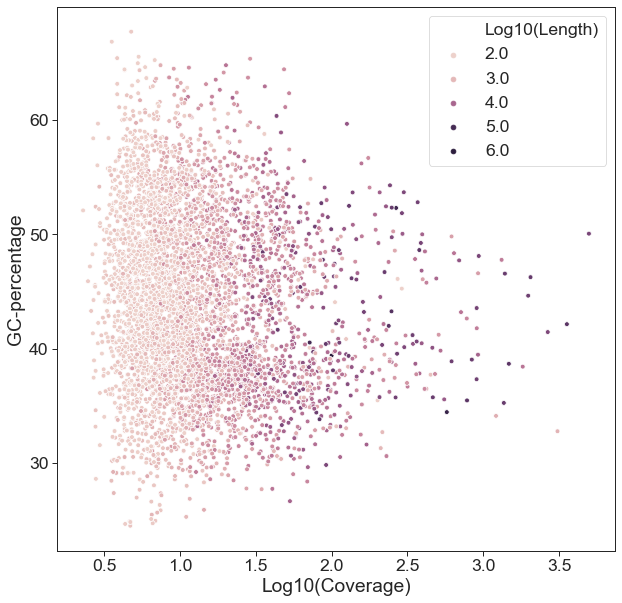

In [4]:
#GC percentage & length
#Read in raw fasta to calculate GC & take length from contigname
sns.set_context("paper", font_scale=2)
fasGClis = []
for record in SeqIO.parse("data/Putativephage_DNARNA.fna", "fasta"):
    templen = np.log10(int(record.id.split('_')[4]) + 1)
    seqnam = record.id
    tempgc = GC(record.seq)
    fasGClis.append([seqnam,templen,tempgc])
GCpd = pd.DataFrame(fasGClis)
GCpd.columns = ['contigname','LogLength','GC']
#Import coverage stats from bamm output
covdf = pd.read_csv('data/coverage_tpmean.tsv', sep='\t', index_col=0)
covdf = covdf.drop(columns=['Length'])
#Take highest coverage per contig:
covmax = pd.DataFrame(covdf.max(axis=1))
covmax.columns = ['Cov']
covmax['contigname'] = covmax.index
#Combine GC dataframe with coverages:
cov_gc = pd.merge(covmax, GCpd, on='contigname', how='outer')
cov_gc['Covlog'] = np.log10(1 + cov_gc['Cov'])
cov_gc.columns = ['Coverage', 'contigname','Log10(Length)', 'GC-percentage','Log10(Coverage)']
plt.figure(figsize=(10,10))
g = sns.scatterplot('Log10(Coverage)','GC-percentage',data=cov_gc, hue="Log10(Length)")
g.figure.savefig('figures/CoveragevsGC.png', dpi=300)

In [5]:
#Parse data from different outputs to construct df 'phage_stats.csv'
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import os
virsortlist = []
diamondlist = []
circularlist = []
ORFlist = []
numGENE = {}
numVOG = {}
numVOG3 = {}
numLEN = {}
with open('data/VIRSorter_global-phage-signal.csv') as f:
    for line in f:
        if not line.startswith('#'):
            if 'circular' not in line.strip().split(',')[0].replace('VIRSorter_',''):
                virsortlist.append(line.strip().split(',')[0].replace('VIRSorter_',''))
            if 'circular' in line.strip().split(',')[0].replace('VIRSorter_',''):
                circularlist.append(line.strip().split(',')[0].replace('VIRSorter_','').replace('-circular',''))
with open('data/Putativephage_DNARNA.fna') as f:
    for line in f:
        if line.startswith('>'):
            if line.strip().replace('>','') not in virsortlist:
                diamondlist.append(line.strip().replace('>',''))
with open('data/Putativephage_DNARNA.faa') as f:
    for line in f:
        if line.startswith('>'):
            ORFlist.append(line.strip().split(' ')[0].replace('>',''))
for f in ORFlist:
    if '_'.join(f.split('_')[:-1]) not in numGENE:
        numGENE['_'.join(f.split('_')[:-1])] = 1
    else:
        numGENE['_'.join(f.split('_')[:-1])] += 1
totlist = virsortlist + diamondlist
for f in totlist:
    numLEN[f] = int(f.split('_')[4])
vogtracker = []
with open('data/TotalhitEVAL5.hmmout') as f:
    for line in f:
        if line.strip().split(' ')[0] not in vogtracker:
            vogtracker.append(line.strip().split(' ')[0])
            if '_'.join(line.strip().split(' ')[0].split('_')[:-1]) not in numVOG:
                numVOG['_'.join(line.strip().split(' ')[0].split('_')[:-1])] = 1
            else:
                numVOG['_'.join(line.strip().split(' ')[0].split('_')[:-1])] += 1
vogtracker = []
with open('data/TotalhitEVAL3.hmmout') as f:
    for line in f:
        if line.strip().split(' ')[0] not in vogtracker:
            vogtracker.append(line.strip().split(' ')[0])
            if '_'.join(line.strip().split(' ')[0].split('_')[:-1]) not in numVOG3:
                numVOG3['_'.join(line.strip().split(' ')[0].split('_')[:-1])] = 1
            else:
                numVOG3['_'.join(line.strip().split(' ')[0].split('_')[:-1])] += 1
combodic = {}
for key in numLEN:
    lenstr = numLEN[key]
    loglenstr = math.log10(numLEN[key])
    if key in numGENE:
        genestr = numGENE[key]
    else:
        genestr = 0
    if key in numVOG:
        vogstr = numVOG[key]
    else:
        vogstr = 0
    if key in numVOG3:
        vogstr3 = numVOG3[key]
    else:
        vogstr3 = 0
    vqstr = round(float(vogstr/genestr),2)
    vqstr3 = round(float(vogstr3/genestr),2)
    if key in virsortlist:
        idstr = 'Virsort'
    if key in diamondlist:
        idstr = 'Diamond'
    if key in circularlist:
        circstr = 'Circ'
    else:
        circstr = 'Lin'
    totlist = [int(lenstr),float(loglenstr),genestr,vogstr,vogstr3,vqstr,vqstr3,idstr,circstr]
    combodic[key] = totlist
phagedf = pd.DataFrame.from_dict(combodic)
phagedf = phagedf.T
phagedf.columns=['Length','LogLength','Numgene','numVOG','numVOG3','pVOG/ORF','VQ3','ID','const']

#Get data from from pVOGs
protVOG = {}
vogtracker = []
with open('data/TotalhitEVAL5.hmmout') as f:
    for line in f:
        if line.strip().split(' ')[0] not in protVOG:
            vognum = line.strip().split(' ')[2]
            evalue = line.strip().split(' ')[4]
            templis = [vognum, evalue]
            protVOG[line.strip().split(' ')[0]] = [templis]
        else:
            vognum = line.strip().split(' ')[2]
            evalue = line.strip().split(' ')[4]
            templis = [vognum, evalue]
            protVOG[line.strip().split(' ')[0]].append(templis)
        if len(line.strip().split(' ')[0].split('_')) != 9:
            print(line.strip().split(' ')[0])
protVOGcur = {}
for i in protVOG:
    if len(protVOG[i]) == 1:
        protVOGcur[i] = protVOG[i]
    if len(protVOG[i]) > 1:
        for j in protVOG[i]:
            if j[1] == min(protVOG[i], key=lambda x: x[1]):
                protVOGcur[i] = j
vqdf = pd.read_csv('data/VQ_vogsite.txt',sep='\t')
for i in protVOGcur:
    protVOGcur[i] = vqdf[vqdf['VOG'] == protVOGcur[i][0][0]].iloc[0]['Virusness']
vqdic = {}
for i in protVOGcur:
    contigname = '_'.join(i.split('_')[:-1])
    if contigname in vqdic:
        vqdic[contigname].append(protVOGcur[i])
    else:
        vqdic[contigname] = [protVOGcur[i]]
vqdicmean = {}
for i in vqdic:
    vqdicmean[i] = [sum(vqdic[i])/len(vqdic[i])]
tempdf = pd.DataFrame.from_dict(vqdicmean,orient='index')
tempdf.columns =['Virusness']
phagedf = phagedf.join(tempdf, how='outer')
phagedf = phagedf.fillna(0)
phagedf.to_csv('output/Phages_stats.csv')

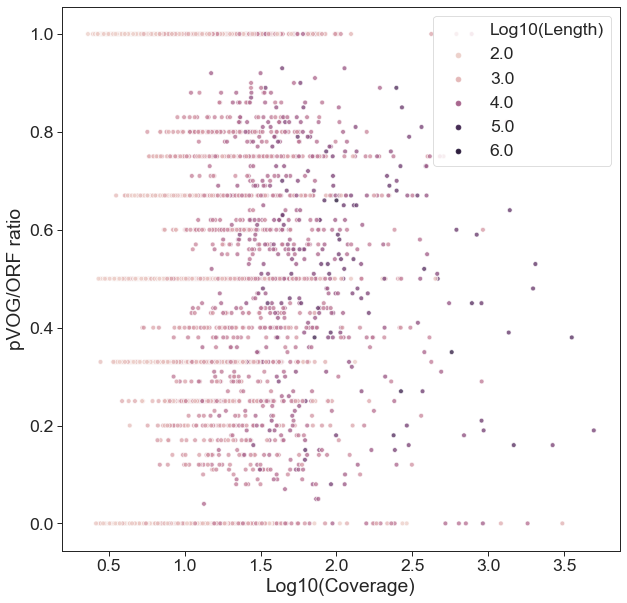

In [6]:
#Plot VQ and distributions
phagedf = pd.read_csv('output/Phages_stats.csv')
phagedf.columns = ['contigname','Length','Log10(Length)','Numgene','numVOG','numVOG3','pVOG/ORF ratio','VQ3','ID','const','Virusness']
phagedf = phagedf.drop(columns='Log10(Length)')
phagecov = pd.merge(phagedf, cov_gc, on='contigname', how='outer')
#contigmodul = pd.read_csv('data/contigs_modularityinfo.csv')
#contigmodul.columns = ['contigname','Group']
#phagecov_mod = pd.merge(phagecov, contigmodul, on='contigname',how='outer')
plt.figure(figsize=(10,10))
g = sns.scatterplot(x="Log10(Coverage)", y="pVOG/ORF ratio",data=phagecov, alpha=0.8, hue="Log10(Length)")
g.figure.savefig('figures/CoveragevspVOG.png', dpi=300)

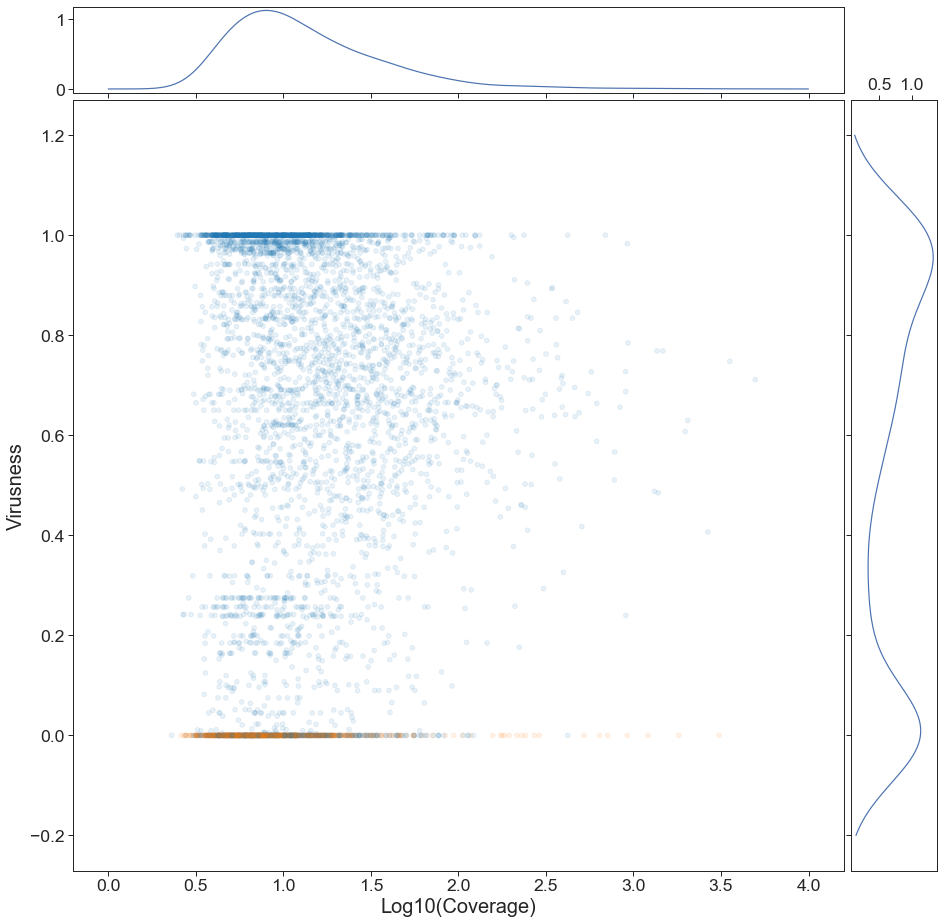

In [8]:
fig, axScatter = plt.subplots(figsize=(15, 15))
fig.subplots_adjust(.1,.1,.9,.9)
font = {'family': 'arial','size': 16,}
phagecov['col_vogorfrat'] = '#1f77b4'
phagecov.loc[phagecov['pVOG/ORF ratio'] == 0, 'col_vogorfrat'] = '#ff7f0e'

axScatter.scatter(phagecov['Log10(Coverage)'], phagecov['Virusness'], alpha=0.1,  c=phagecov['col_vogorfrat'])
axScatter.set_xlabel('Log10(Coverage)', size=20)
axScatter.set_ylabel('Virusness', size=20)
divider = make_axes_locatable(axScatter)
ax1 = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
ax2 = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

## make some labels invisible
ax1.tick_params(labelbottom=False, bottom=True, 
                    left=True, labelleft=True, right=False, labelright=False)
ax2.tick_params(labelleft=False, left=True, 
                    bottom=False, labelbottom=False, top=True, labeltop=True)

covdensity = stats.kde.gaussian_kde(phagecov['Log10(Coverage)'])
covdensity.covariance_factor = lambda : .25
covdensity._compute_covariance()
xs = np.linspace(0,4,200)
ax1.plot(xs, covdensity(xs))
ax1.axis('on')

virdensity = stats.kde.gaussian_kde(phagecov['Virusness'])
virdensity.covariance_factor = lambda : .25
virdensity._compute_covariance()
xs = np.linspace(-0.2,1.2,200)
ax2.plot(virdensity(xs),xs)

fig.savefig('figures/CoveragevsVirusness.png', dpi=300)

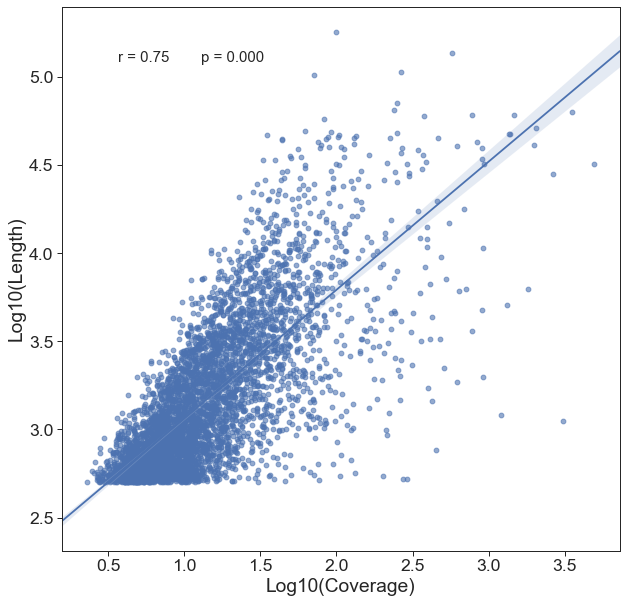

In [9]:
(r, p) = spearmanr(phagecov['Log10(Coverage)'], phagecov['Log10(Length)'])
plt.figure(figsize=(10,10))
g = sns.regplot(x="Log10(Coverage)", y="Log10(Length)", data=phagecov, scatter_kws={'alpha':0.6})
g.annotate("r = {:.2f} ".format(r), xy=(.1, .9), xycoords=g.transAxes, size=15)
g.annotate("p = {:.3f}".format(p),xy=(.25, .9), xycoords=g.transAxes, size=15)
g.figure.savefig('figures/CoveragevsLength.png', dpi=300)

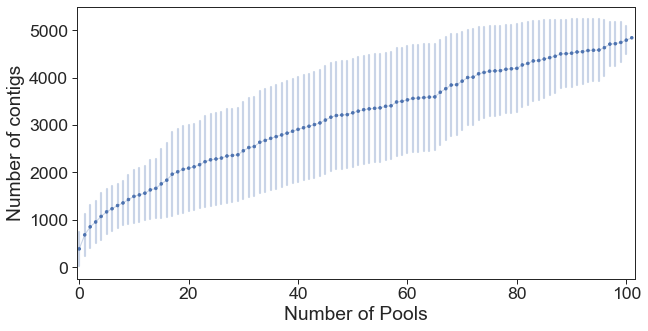

In [10]:
#Species accumulation curve results
spec = pd.read_csv("data/speccaccummat.csv", sep=",", index_col=0)
spec['idvar'] = spec.index
spec = pd.melt(spec, id_vars=['idvar'])

plt.figure(figsize=(10,5))

g = sns.pointplot(spec['idvar'], spec['value'],ci="sd", scale=0.5)
g.set(xlabel="Number of Pools",ylabel="Number of contigs")
g.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
g.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
plt.setp(g.lines, alpha=.3)
g.figure.savefig('figures/specaccum.png', dpi=300)

In [12]:
################################################# PART 2 #################################################

In [11]:
#Bacteriophages _ host --> Parse IMG/M id's and accessions to names. 
#Create link between contig id & bacterial name
import pandas as pd
link = pd.read_csv('data/Link_GA_bacterium.txt', sep='\t')
link2 = pd.read_csv('data/contignames.txt', sep='\t')
link3 = pd.merge(link, link2, on='Link')

link3.to_csv('output/linkfin.txt', sep='\t', index=False)

#Create dictionary out of it for renaming downstream
link = {}
with open('output/linkfin.txt') as f:
    for line in f:
        if line.split()[0] != 'Link':
            link[line.split()[2]] = line.split()[1]

In [12]:
#Calculate how many contigs have spacers that match a specific bacterium.
JGIhit = {}
with open('data/Crisprhits_red.bln') as f:
    for line in f:
        if 'CRISPR' in line:
            bacname = link[line.strip().split()[0].split('_')[0]]
            if bacname not in JGIhit:
                JGIhit[bacname] = [line.strip().split()[1]]
            else:
                if line.strip().split()[1] not in JGIhit[bacname]:
                    JGIhit[bacname].append(line.strip().split()[1])
#Grab number of contigs that have at least 1 spacer hit to each bacterium
JGIhitnumber = {}
for i in JGIhit:
    JGIhitnumber[i] = len(JGIhit[i])
with open ("data/bacteria_names.txt") as f:
    for line in f:
        if line.strip() not in JGIhitnumber:
            JGIhitnumber[line.strip()] = 0
JGIdf = pd.DataFrame(JGIhitnumber, index=['Num_Contigs'])
JGIdf = JGIdf.T
JGIdf.to_csv("output/contigshits.csv", sep="\t")

#Count number of unique contigs:
foundcon = []
for i in JGIhit:
    for j in JGIhit[i]:
        if j not in foundcon:
            foundcon.append(j)
print(len(foundcon))

#Count groups:
Lactobacillus = []
Gilliamella = []
Bifidobacterium = []
for i in JGIhit:
    if 'Lacto' in str(i):
        for j in JGIhit[i]:
            if j not in Lactobacillus:
                Lactobacillus.append(j)
    if 'Gilliamella' in str(i):
        for j in JGIhit[i]:
            if j not in Gilliamella:
                Gilliamella.append(j)
    if 'Bifido' in str(i):
        for j in JGIhit[i]:
            if j not in Bifidobacterium:
                Bifidobacterium.append(j)
print('Lacto: ' + str(len(Lactobacillus)))
print('Gillia: ' + str(len(Gilliamella)))
print('Bifido: ' + str(len(Bifidobacterium)))

76
Lacto: 32
Gillia: 17
Bifido: 27


In [13]:
#Get an idea on how many contigs have multiple hosts!
contigvsbac = {}
with open('data/Crisprhits_red.bln') as f:
    for line in f:
        if 'CRISPR' in line:
            bacname = link[line.strip().split()[0].split('_')[0]]
            contigname = line.strip().split()[1]
            if contigname not in contigvsbac:
                contigvsbac[contigname] = [bacname]
            else:
                if bacname not in contigvsbac[contigname]:
                    contigvsbac[contigname].append(bacname)
#Create dictionary which maps a bacterium to a number. (we use '1'-indexed system).
bacnum = {}
counter = 1
for i in contigvsbac:
    for j in contigvsbac[i]:
        if j not in bacnum:
            bacnum[j] = counter
            counter += 1
taxlinklist = []
#Max length is 5, so we make statements from 2 - 5 for each (not a good, but a fast solution):
for i in contigvsbac:
    if len(contigvsbac[i]) == 2:
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][1]])
    if len(contigvsbac[i]) == 3:
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][1]])
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][2]])
        taxlinklist.append([i,contigvsbac[i][1],contigvsbac[i][2]])
    if len(contigvsbac[i]) == 4:
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][1]])
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][2]])
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][3]])
        taxlinklist.append([i,contigvsbac[i][1],contigvsbac[i][2]])
        taxlinklist.append([i,contigvsbac[i][1],contigvsbac[i][3]])
        taxlinklist.append([i,contigvsbac[i][2],contigvsbac[i][3]])
    if len(contigvsbac[i]) == 5:
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][1]])
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][2]])
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][3]])
        taxlinklist.append([i,contigvsbac[i][0],contigvsbac[i][4]])
        taxlinklist.append([i,contigvsbac[i][1],contigvsbac[i][2]])
        taxlinklist.append([i,contigvsbac[i][1],contigvsbac[i][3]])
        taxlinklist.append([i,contigvsbac[i][1],contigvsbac[i][4]])
        taxlinklist.append([i,contigvsbac[i][2],contigvsbac[i][3]])
        taxlinklist.append([i,contigvsbac[i][2],contigvsbac[i][4]])
        taxlinklist.append([i,contigvsbac[i][3],contigvsbac[i][4]])
#Taxlinklist to pandas df
taxdf = pd.DataFrame(taxlinklist)
taxdf.columns = ["Node","Bac1","Bac2"]
taxdf.to_csv("output/multihostlink.csv")
for i in contigvsbac:
    if len(contigvsbac[i]) == 1:
        print(i)

BP3_NODE_11_length_5694_cov_3_924816
BP3_NODE_20_length_3931_cov_2_478478
BeeP-37-2013_NODE_25_length_6004_cov_14_639784
BeeP-11-2013_NODE_255_length_4427_cov_17_496322
BP33_NODE_2_length_30045_cov_21_759190
BeeP-25-2013_NODE_77_length_3407_cov_18_130030
BP23_NODE_11_length_12964_cov_6_093436
BeeP-49-2013_NODE_7_length_16289_cov_58_100234
BP35_NODE_10_length_5818_cov_2_933123
BP49_NODE_2_length_32306_cov_7_451888
BP33_NODE_75_length_2173_cov_1_061891
BeeP-17-2013_NODE_26_length_5209_cov_7_417771
BP44_NODE_5_length_3908_cov_0_687087
BP24_NODE_21_length_3840_cov_2_635924
BP33_NODE_5_length_18448_cov_6_639330
BP24_NODE_41_length_3208_cov_1_381276
BP19_NODE_8_length_11484_cov_2_892898
BP19_NODE_16_length_6089_cov_4_880697
BeeP-35-2013_NODE_606_length_1936_cov_7_160301
BeeP-49-2013_NODE_119_length_2893_cov_5_172585
BP49_NODE_6_length_13426_cov_7_108305
BeeP-05-2013_NODE_35_length_4077_cov_7_456000
BeeP-27-2013_NODE_8_length_2163_cov_2_940556
BP49_NODE_4_length_25564_cov_9_867154
BP31_NODE_2

In [14]:
#Read in tRNA data
linkdic = {}
with open("output/linkfin.txt") as f:
    for line in f:
        linkdic[line.strip().split()[2]] = line.strip().split()[1]
tRNAhits = {}
tRNArev = {}
with open("data/alltRNA_BACJGI_genomeacc.bln") as f:
    for line in f:
        contigname = '_'.join(line.strip().split()[0].split('_')[0:8])
        hitscaf = line.strip().split()[1]
        bachit = linkdic[hitscaf]
        if contigname in tRNAhits:
            if bachit not in tRNAhits[contigname]:
                tRNAhits[contigname].append(bachit)
        else:
            tRNAhits[contigname] = [bachit]
        if bachit not in tRNArev:
            tRNArev[bachit] = [contigname]
        else:
            if contigname not in tRNArev[bachit]:
                tRNArev[bachit].append(contigname)

bachit_trnanum = {}                
for i in tRNArev:
    bachit_trnanum[i] = len(tRNArev[i])
with open ("data/bacteria_names.txt") as f:
    for line in f:
        if line.strip() not in bachit_trnanum:
            bachit_trnanum[line.strip()] = 0
tRNAdf = pd.DataFrame(bachit_trnanum, index=['Num_Contigs'])
tRNAdf = tRNAdf.T
tRNAdf.to_csv("output/contigshits_tRNA.csv", sep="\t")
tRNAhits

{'BeeP-11-2013_NODE_389_length_3323_cov_4_689464': ['Lactobacillus_mellifer_Bin4'],
 'BeeP-11-2013_NODE_5233_length_704_cov_4_496013': ['Frischella_perrara_Fp_167'],
 'BeeP-25-2013_NODE_22_length_6759_cov_51_306196': ['Lactobacillus_helsingborgensis_Bma5',
  'Lactobacillus_melliventris_Hma8',
  'Lactobacillus_kullabergensis_Biut2',
  'Lactobacillus_apis_Hma11',
  'Lactobacillus_kimbladii_Hma2',
  'Lactobacillus_helsinborgensis_Lb_183',
  'Lactobacillus_melliventris_Lb_184',
  'Lactobacillus_apis_Lb_185',
  'Lactobacillus_kullabergensis_Lb_186'],
 'BeeP-47-2013_NODE_14_length_4062_cov_10_046675': ['Lactobacillus_melliventris_Lb_184'],
 'BP19_NODE_1_length_107175_cov_15_429755': ['Bifidobacterium_asteroides_Hma3',
  'Bifidobacterium_coryneforme_Bma6',
  'Bifidobacterium_asteroides_Bin7',
  'Bifidobacterium_asteroides_Bin2',
  'Bifidobacterium_asteroides_Bi_200',
  'Bifidobacterium_asteroides_Bi_199',
  'Bifidobacterium_asteroides_Bi_198',
  'Bifidobacterium_coryneforme_Bi_197',
  'Bifido

In [15]:
#Overlap for 1 node tied with multiple bacteria:
for i in tRNAhits:
    if len(tRNAhits[i]) > 1:
        print(len(tRNAhits[i]))
#Both are of length 9, to iterate:
counter = 0
multihost_tRNA = []
for i in tRNAhits:
    if len(tRNAhits[i]) > 1:
        multihost_tRNA.append([counter,i,tRNAhits[i][0],tRNAhits[i][1]])
        multihost_tRNA.append([counter,i,tRNAhits[i][0],tRNAhits[i][2]])
        multihost_tRNA.append([counter,i,tRNAhits[i][0],tRNAhits[i][3]])
        multihost_tRNA.append([counter,i,tRNAhits[i][0],tRNAhits[i][4]])
        multihost_tRNA.append([counter,i,tRNAhits[i][0],tRNAhits[i][5]])
        multihost_tRNA.append([counter,i,tRNAhits[i][0],tRNAhits[i][6]])
        multihost_tRNA.append([counter,i,tRNAhits[i][0],tRNAhits[i][7]])
        multihost_tRNA.append([counter,i,tRNAhits[i][0],tRNAhits[i][8]])
        multihost_tRNA.append([counter,i,tRNAhits[i][1],tRNAhits[i][2]])
        multihost_tRNA.append([counter,i,tRNAhits[i][1],tRNAhits[i][3]])
        multihost_tRNA.append([counter,i,tRNAhits[i][1],tRNAhits[i][4]])
        multihost_tRNA.append([counter,i,tRNAhits[i][1],tRNAhits[i][5]])
        multihost_tRNA.append([counter,i,tRNAhits[i][1],tRNAhits[i][6]])
        multihost_tRNA.append([counter,i,tRNAhits[i][1],tRNAhits[i][7]])
        multihost_tRNA.append([counter,i,tRNAhits[i][1],tRNAhits[i][8]])
        multihost_tRNA.append([counter,i,tRNAhits[i][2],tRNAhits[i][3]])
        multihost_tRNA.append([counter,i,tRNAhits[i][2],tRNAhits[i][4]])
        multihost_tRNA.append([counter,i,tRNAhits[i][2],tRNAhits[i][5]])
        multihost_tRNA.append([counter,i,tRNAhits[i][2],tRNAhits[i][6]])
        multihost_tRNA.append([counter,i,tRNAhits[i][2],tRNAhits[i][7]])
        multihost_tRNA.append([counter,i,tRNAhits[i][2],tRNAhits[i][8]])
        multihost_tRNA.append([counter,i,tRNAhits[i][3],tRNAhits[i][4]])
        multihost_tRNA.append([counter,i,tRNAhits[i][3],tRNAhits[i][5]])
        multihost_tRNA.append([counter,i,tRNAhits[i][3],tRNAhits[i][6]])
        multihost_tRNA.append([counter,i,tRNAhits[i][3],tRNAhits[i][7]])
        multihost_tRNA.append([counter,i,tRNAhits[i][3],tRNAhits[i][8]])
        multihost_tRNA.append([counter,i,tRNAhits[i][4],tRNAhits[i][5]])
        multihost_tRNA.append([counter,i,tRNAhits[i][4],tRNAhits[i][6]])
        multihost_tRNA.append([counter,i,tRNAhits[i][4],tRNAhits[i][7]])
        multihost_tRNA.append([counter,i,tRNAhits[i][4],tRNAhits[i][8]])
        multihost_tRNA.append([counter,i,tRNAhits[i][5],tRNAhits[i][6]])
        multihost_tRNA.append([counter,i,tRNAhits[i][5],tRNAhits[i][7]])
        multihost_tRNA.append([counter,i,tRNAhits[i][5],tRNAhits[i][8]])
        multihost_tRNA.append([counter,i,tRNAhits[i][6],tRNAhits[i][7]])
        multihost_tRNA.append([counter,i,tRNAhits[i][6],tRNAhits[i][8]])
        counter +=1
multihost_tRNAdf = pd.DataFrame(multihost_tRNA)
multihost_tRNAdf.columns = ["Contignumber","Node","Bac1","Bac2"]
multihost_tRNAdf.to_csv("output/multihost_trna.csv", index=False)

9
9


In [16]:
#New type of structure for the links
#Create dictionary out of it for renaming downstream
link = {}
with open('output/linkfin.txt') as f:
    for line in f:
        if line.split()[0] != 'Link':
            link[line.split()[2]] = line.split()[1]
#Calculate how many contigs have spacers that match a specific bacterium.
JGIhit = {}
with open('data/Crisprhits_red.bln') as f:
    for line in f:
        if 'CRISPR' in line:
            bacname = link[line.strip().split()[0].split('_')[0]]
            if bacname not in JGIhit:
                JGIhit[bacname] = [line.strip().split()[1]]
            else:
                if line.strip().split()[1] not in JGIhit[bacname]:
                    JGIhit[bacname].append(line.strip().split()[1])
hitneslis = []
for i in JGIhit:
    for j in JGIhit[i]:
        hitneslis.append(j)
contignum = {}
for i in hitneslis:
    if i not in contignum:
        contignum[i] = hitneslis.count(i)
findic = {}
for i in JGIhit:
    templis = []
    for j in JGIhit[i]:
        templis.append(contignum[j])
    findic[i] = templis
findic2 = {}
for i in findic:
    findic2[i] = dict(Counter(findic[i]))
counterdf = pd.DataFrame(findic2)
counterdf = counterdf.fillna(0)
counterdf = counterdf.T
counterdf.to_csv("output/crisprcounts.csv")

In [17]:
# Any antismash contigs here?
antismash = ['BeeP-11-2013_NODE_10_length_45562_cov_39_780829','BeeP-11-2013_NODE_169_length_5958_cov_160_716545','BeeP-11-2013_NODE_890_length_1940_cov_18_632850','BeeP-38-2013_NODE_1_length_47472_cov_756_510180']
for i in JGIdf:
    for j in JGIdf[i]:
        if j in antismash:
            print(str(j) + ' ' + str(i))
for i in tRNAhits:
    if i in antismash:
        print(i)
        
#No...

In [20]:
################################################# PART 3 #################################################

In [18]:
#Phate dimension red.
#Dead and alive lists:
tpmean = pd.read_csv("data/coverage_tpmean.tsv", sep="\t")
del tpmean['Length']
tpmean = tpmean.set_index(tpmean['#contig'])
del tpmean['#contig']
Dead = ['BP2','BP4','BP7','BP8','BP9','BP12','BP14','BP15','BP18','BP20','BP22','BP24','BP25','BP27','BP30','BP31','BP32','BP33','BP36','BP38','BP40','BP42','BP44','BP47','BP48','BeeP-01-2013','BeeP-04-2013','BeeP-05-2013','BeeP-07-2013','BeeP-09-2013','BeeP-11-2013','BeeP-13-2013','BeeP-15-2013','BeeP-16-2013','BeeP-18-2013','BeeP-19-2013','BeeP-23-2013','BeeP-24-2013','BeeP-26-2013','BeeP-29-2013','BeeP-31-2013','BeeP-33-2013','BeeP-34-2013','BeeP-37-2013','BeeP-38-2013','BeeP-41-2013','BeeP-44-2013','BeeP-46-2013','BeeP-48-2013','BeeP-50-2013','BeeP-Q2-2013']
Alive = ['BP1','BP3','BP5','BP6','BP10','BP11','BP13','BP16','BP17','BP19','BP21','BP23','BP26','BP26','BP28','BP29','BP34','BP35','BP37','BP39','BP41','BP43','BP45','BP46','BP49','BP50','BeeP-02-2013','BeeP-03-2013','BeeP-06-2013','BeeP-08-2013','BeeP-10-2013','BeeP-12-2013','BeeP-14-2013','BeeP-17-2013','BeeP-20-2013','BeeP-21-2013','BeeP-22-2013','BeeP-25-2013','BeeP-27-2013','BeeP-28-2013','BeeP-30-2013','BeeP-32-2013','BeeP-35-2013','BeeP-36-2013','BeeP-39-2013','BeeP-40-2013','BeeP-42-2013','BeeP-43-2013','BeeP-45-2013','BeeP-47-2013','BeeP-49-2013','BeeP-Q1-2013']
colcolum = []
for i in tpmean.T.index:
    if i.replace("_filtered.bam","") in Dead:
        colcolum.append('Weak')
    if i.replace("_filtered.bam","") in Alive:
        colcolum.append('Healthy')

In [19]:
#Phate
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(tpmean.T.values)
data_phate

Calculating PHATE...
  Running PHATE on 102 cells and 4842 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.15 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.17 seconds.
  Calculating optimal t...
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.03 seconds.
Calculated PHATE in 0.22 seconds.


array([[-4.03522113e-02,  2.71407586e-03],
       [-2.99133103e-02,  1.58054866e-03],
       [-6.03059260e-02, -1.06680506e-02],
       [ 6.95800227e-04,  9.42161948e-03],
       [-4.09829784e-02, -5.99331009e-03],
       [-5.85423932e-02, -9.72877714e-03],
       [-3.88882359e-02,  9.36670357e-03],
       [-2.29716640e-03, -1.71683947e-02],
       [ 1.65724850e-01, -1.97856887e-02],
       [ 7.17751537e-02,  1.66496480e-01],
       [ 7.03822194e-02, -3.51468177e-03],
       [ 2.32133319e-01, -2.00777726e-02],
       [-5.22594905e-02, -6.23049163e-03],
       [-4.42972342e-02,  3.47777263e-03],
       [ 4.31137333e-01, -4.27339335e-03],
       [ 1.73770147e-01, -1.97384986e-02],
       [-1.93015423e-02,  1.09796872e-02],
       [-4.65495211e-03,  5.29462453e-03],
       [-4.21926604e-02,  1.22750207e-03],
       [-4.65162343e-02, -4.14014579e-03],
       [-4.52751478e-02,  2.44675994e-03],
       [-6.10733092e-02, -1.16424936e-02],
       [-3.89155228e-02, -1.46866342e-02],
       [-2.

In [39]:
#Create DF with metadata to later use in adonis test and PCoA (in R).
phatedf = pd.DataFrame(data_phate)
phatedf.columns = ['Dim1','Dim2']
phatedf['Status'] = colcolum
phatedf['Year'] = colcolumn_year
phatedf['Location'] = colcolumn_prov
del phatedf['Dim1']
del phatedf['Dim2']
phatedf['Sample'] = ['BP1' , 'BP2' , 'BP3' , 'BP4' , 'BP5' , 'BP6' , 'BP7' , 'BP8' , 'BP9' , 'BP10' , 'BP11' , 'BP12' , 'BP13' , 'BP14' , 'BP15' , 'BP16' , 'BP17' , 'BP18' , 'BP19' , 'BP20' , 'BP21' , 'BP22' , 'BP23' , 'BP24' , 'BP25' , 'BP26' , 'BP27' , 'BP28' , 'BP29' , 'BP30' , 'BP31' , 'BP32' , 'BP33' , 'BP34' , 'BP35' , 'BP36' , 'BP37' , 'BP38' , 'BP39' , 'BP40' , 'BP41' , 'BP42' , 'BP43' , 'BP44' , 'BP45' , 'BP46' , 'BP47' , 'BP48' , 'BP49' , 'BP50' , 'BeeP-01-2013' , 'BeeP-02-2013' , 'BeeP-03-2013' , 'BeeP-04-2013' , 'BeeP-05-2013' , 'BeeP-06-2013' , 'BeeP-07-2013' , 'BeeP-08-2013' , 'BeeP-09-2013' , 'BeeP-10-2013' , 'BeeP-11-2013' , 'BeeP-12-2013' , 'BeeP-13-2013' , 'BeeP-14-2013' , 'BeeP-15-2013' , 'BeeP-16-2013' , 'BeeP-17-2013' , 'BeeP-18-2013' , 'BeeP-19-2013' , 'BeeP-20-2013' , 'BeeP-21-2013' , 'BeeP-22-2013' , 'BeeP-23-2013' , 'BeeP-24-2013' , 'BeeP-25-2013' , 'BeeP-26-2013' , 'BeeP-27-2013' , 'BeeP-28-2013' , 'BeeP-29-2013' , 'BeeP-30-2013' , 'BeeP-31-2013' , 'BeeP-32-2013' , 'BeeP-33-2013' , 'BeeP-34-2013' , 'BeeP-35-2013' , 'BeeP-36-2013' , 'BeeP-37-2013' , 'BeeP-38-2013' , 'BeeP-39-2013' , 'BeeP-40-2013' , 'BeeP-41-2013' , 'BeeP-42-2013' , 'BeeP-43-2013' , 'BeeP-44-2013' , 'BeeP-45-2013' , 'BeeP-46-2013' , 'BeeP-47-2013' , 'BeeP-48-2013' , 'BeeP-49-2013' , 'BeeP-50-2013' , 'BeeP-Q1-2013' , 'BeeP-Q2-2013']
phatedf.to_csv("output/Sample_metadata.csv", sep='\t')

In [ ]:
##################### CrisprDB results ##################### 
#Grab contigs that are classified already:
clas_jgi = [i for j in JGIhit.values() for i in j]
clas_jgi

#Load blast results, first check out the contigs that had no previous hits before!
bachits = {}
with open('data/phage_crisprdb.bln') as f:
    for line in f:
        if line.strip().split('\t')[1] not in clas_jgi:
            if line.strip().split('\t')[1] not in bachits:
                bachits[line.strip().split('\t')[1]] = [line.strip().split('\t')[0]]
            else:
                if line.strip().split('\t')[0] not in bachits[line.strip().split('\t')[1]]:
                    bachits[line.strip().split('\t')[1]].append(line.strip().split('\t')[0])
bachits

In [ ]:
##Add the bacterial information.
bacclasdic = {
    'AOOM01000229.1|CM001838.1':'Dickeya dianthicola GBBC 2039|Dickeya dianthicola GBBC 2039',
     'AP017381.1':'Moraxella osloensis DNA',
     'AP017469.1':'Hafnia sp. CBA7124 DNA',
     'CM001838.1':'Dickeya dianthicola GBBC 2039',
     'CM001840.1':'Dickeya dianthicola NCPPB 3534',
     'CM001840.1|CM002023.1':'Dickeya dianthicola NCPPB 3534|Dickeya dianthicola IPO 980',
     'CM001841.1|CP017638.1':'Dickeya dianthicola NCPPB 453|Dickeya dianthicola RNS04.9',
     'CM001980.1':'Dickeya zeae NCPPB 3531',
     'CM002023.1':'Dickeya dianthicola IPO 980',
     'CM004509.1':'Gilliamella apicola strain wkB7',
     'CM008894.1':'Serratia marcescens strain 12TM',
     'CP003218.1|CP003683.1|CP023185.1|CP004887.1|CP022348.1':'Klebsiella michiganensis strain KCTC 1686|Klebsiella michiganensis E718|Klebsiella michiganensis strain K518|Klebsiella michiganensis HKOPL1|Klebsiella michiganensis strain K516',
     'CP003244.1':'Rahnella aquatilis',
     'CP003325.1|CP017696.1':'Bifidobacterium asteroides PRL2011|Bifidobacterium asteroides strain DSM 20089',
     'CP007445.1':'Gilliamella apicola strain wkB1',
     'CP008920.1':'Providencia stuartii strain ATCC 33672',
     'CP008943.1':'Yersinia pseudotuberculosis',
     'CP009450.1':'Pluralibacter gergoviae strain FB2',
     'CP009706.1':'Hafnia alvei FB1',
     'CP010423.1':'Pragia fontium strain 24613',
     'CP011254.1':'Serratia fonticola strain DSM 4576',
     'CP015625.1':'Bartonella apis strain BBC0122',
     'CP015820.1':'Bartonella apis strain BBC0178',
     'CP015821.1':'Bartonella apis strain BBC0244',
     'CP017184.1':'Enterobacter roggenkampii strain DSM 16690',
     'CP017638.1':'Dickeya dianthicola RNS04.9',
     'CP023005.1':'Bifidobacterium adolescentis strain 6',
     'CP025084.1|CP025085.1':'Serratia sp. ATCC 39006|Serratia sp. ATCC 39006',
     'CP026116.1':'Lactobacillus curvatus JCM 1096 = DSM 20019',
     'CP031513.1':'Lactobacillus bombi strain BI-2.5',
     'CP031560.1':'Dickeya dianthicola strain ME23',
     'CP038281.1':'Raoultella ornithinolytica',
     'LR134136.1':'Atlantibacter hermannii strain NCTC12129',
     'LR590464.1':'Leclercia adecarboxylata strain NCTC13032',
     'LT841333.1':'Lactobacillus curvatus isolate FLEC03',
     'LT907930.1':'Lactobacillus sakei strain J18',
     'LT907931.1':'Lactobacillus sakei strain J160x1',
     'LT907933.1|LT960790.1|LT960777.1':'Lactobacillus sakei strain J112|Lactobacillus sakei strain J54|Lactobacillus sakei strain FLEC01',
     'LT960777.1|LT960790.1':'Lactobacillus sakei strain FLEC01|Lactobacillus sakei strain J54',
     'LT960790.1':'Lactobacillus sakei strain J54',
     'LT984417.2':'Lactobacillus fuchuensis strain MFPC41A2801',
     'LT992557.1':'Lactococcus piscium strain CMTALT02'}

In [ ]:
bachits2 = {}
for i in bachits:
    templis = []
    for j in bachits[i]:
        templis.append(bacclasdic[j])
    bachits2[i] = templis
bachits2

In [ ]:
#Check at classification of previously linked bacteria:
clas_jgi
clas_bachits = {}
with open('data/phage_crisprdb.bln') as f:
    for line in f:
        if line.strip().split('\t')[1] in clas_jgi:
            if line.strip().split('\t')[1] not in clas_bachits:
                clas_bachits[line.strip().split('\t')[1]] = [line.strip().split('\t')[0].split('|')[0]]
            else:
                if line.strip().split('\t')[0].split('|')[0] not in clas_bachits[line.strip().split('\t')[1]]:
                    clas_bachits[line.strip().split('\t')[1]].append(line.strip().split('\t')[0].split('|')[0])
clas_bachits

In [ ]:
clas_bacclasdic = {'CM004509.1':'Gilliamella apicola strain wkB7' ,
 'CP003325.1':'Bifidobacterium asteroides PRL2011',
 'CP007445.1':'Gilliamella apicola strain wkB1',
 'CP029476.1':'Lactobacillus apis strain ESL0185',
 'CP029477.1':'Lactobacillus kullabergensis strain ESL0186',
 'CP029544.1':'Lactobacillus helsingborgensis strain ESL0183'}

In [ ]:
clas_bachits2 = {}
for i in clas_bachits:
    templis = []
    for j in clas_bachits[i]:
        templis.append(clas_bacclasdic[j])
    clas_bachits2[i] = templis
clas_bachits2

In [ ]:
#Compare the classification of JGIdb with Crisprdb:
JGIhit_rev = {}
for i in JGIhit:
    for j in JGIhit[i]:
        if j in JGIhit_rev:
            if i not in JGIhit_rev[j]:
                JGIhit_rev[j].append(i)
        else:
            JGIhit_rev[j] = [i]
for i in clas_bachits2:
    print(i)
    print('JGIhit: ' + str(JGIhit_rev[i]))
    print('CRISPRdb: '+ str(clas_bachits2[i]))

In [ ]:
clas_bachits2

In [ ]:
hits = []
for i in JGIhit:
    for j in JGIhit[i]:
        if j not in hits:
            hits.append(j)
len(hits)

In [ ]:
JGIhit